# LSTM Rating Classifier using Word Embeddings

Q:
https://www.youtube.com/watch?v=nam2zR7p7Os
https://www.youtube.com/watch?v=Wp-Wb456kSU
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing

In [56]:
import pandas as pd
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences # not preprocessing.sequence (deprecated)
from numpy import asarray , array
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [57]:
yelp = pd.read_csv("../2_text_preprocessing/cleaned_data_yelp.csv",index_col=None)

### Word Embeddings with Keras

In [58]:
from keras.preprocessing.text import Tokenizer

comments_array = asarray(yelp['Tokenized_Comment'])
vocab_size = 1700 #20000
tokenizer=Tokenizer(num_words=vocab_size)
#get index per word
tokenizer.fit_on_texts(comments_array)
#tokenizer.word_index

In [59]:
def int_encode_comments(comment_list, tokenizer):
    return tokenizer.texts_to_sequences(comment_list)

embedded_comments = int_encode_comments(comments_array, tokenizer)
print(embedded_comments[:5])

[[315, 97, 6, 41, 1043], [170, 705, 6, 1302, 83, 167, 985, 241, 287, 5, 736, 17, 96, 83, 1, 60, 32, 532, 249, 1282, 856, 2, 141, 25, 245, 16, 122, 179, 510, 8, 346, 22, 316, 67, 14, 1171, 19, 594, 22, 129, 56, 21, 178, 72, 20, 480, 373, 135, 246, 678, 460, 5, 2, 1044], [136, 319, 14, 213, 527, 60, 210, 18, 435, 790, 102, 29, 14], [1, 62, 289, 140, 585, 907, 309, 635, 6, 60, 1011, 679, 769, 1635, 58, 42, 155, 1012, 16, 122, 10, 481, 1496, 680, 70, 133, 282, 172, 963, 21, 125, 60, 986, 131, 19, 36, 54, 70, 656, 1130, 695, 70, 1000, 2, 141, 908, 1131, 1598, 57, 1153, 46, 345, 50, 239, 277, 569, 16, 21, 97, 814, 678, 473], [146, 47, 202, 447, 23, 447, 1, 737, 28, 345, 1303, 152, 566, 42, 567, 826, 92, 10, 414, 706, 44, 73]]


#### LSTM Model Preparation

1) Define padding size

In [60]:
def get_max_token_length_per_cmt(Comments_arr: list[str])-> int:
    return max(list(map(lambda x: len(x.split()),Comments_arr)))
#padding_size = get_max_token_length_per_cmt(comments_array)
padding_size=300
print(str(padding_size))

300


2) Pad embedded comments

In [61]:
padded_cmts = pad_sequences(embedded_comments, maxlen=padding_size)

3. One-Hot-Encoding of Rating
Q: https://www.atmosera.com/blog/multiclass-classification-with-neural-networks/

In [62]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# need to pre-encode labels (1-5) to (0-4) because to_categorical assumes 0 as lowest label value
# otherwise we would get 6 classes in the one-hot encoded arrays

yelp['Rating_Encoded'] = LabelEncoder().fit_transform(yelp['Rating'])
print(yelp.Rating)
print(to_categorical(yelp.Rating))

0       5
1       4
2       5
3       2
4       5
       ..
9701    3
9702    3
9703    5
9704    5
9705    5
Name: Rating, Length: 9706, dtype: int64
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


#### Train-Dev-Test Split

In [63]:
seed=101010
y=yelp["Rating_Encoded"]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(padded_cmts, y, test_size = 0.1, random_state=seed)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size = 0.1, random_state=seed)


#### Define LSTM Model

In [79]:
from keras import optimizers

model = Sequential()
model.add(Embedding(input_dim=vocab_size,  output_dim=128, input_length=padding_size))
model.add(LSTM(units=200, activation='tanh'))
#model.add(Flatten())
model.add(Dense(5, activation='softmax'))
opt = optimizers.Adam(learning_rate=1e-04) #RMSProp
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 300, 128)          217600    
                                                                 
 lstm_20 (LSTM)              (None, 200)               263200    
                                                                 
 dense_20 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 481,805
Trainable params: 481,805
Non-trainable params: 0
_________________________________________________________________


#### Train LSTM Model with LSTM Layer

In [80]:
hist = model.fit(X_train,
                 to_categorical(y_train),
                 #batch_size=5,
                 epochs=5,
                 validation_data=(X_dev,to_categorical(y_dev)))

Epoch 1/5
246/246 [==============================] - 300s 1s/step - loss: 1.3185 - accuracy: 0.4672 - val_loss: 1.2384 - val_accuracy: 0.4966
Epoch 2/5
246/246 [==============================] - 267s 1s/step - loss: 1.1753 - accuracy: 0.4894 - val_loss: 1.0616 - val_accuracy: 0.5355
Epoch 3/5
246/246 [==============================] - 209s 852ms/step - loss: 1.0195 - accuracy: 0.5473 - val_loss: 1.0127 - val_accuracy: 0.5481
Epoch 4/5
246/246 [==============================] - 219s 890ms/step - loss: 0.9584 - accuracy: 0.5808 - val_loss: 0.9771 - val_accuracy: 0.5584
Epoch 5/5
246/246 [==============================] - 238s 967ms/step - loss: 0.9141 - accuracy: 0.6011 - val_loss: 0.9528 - val_accuracy: 0.5641


In [82]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import numpy as np
pred_test= np.argmax(model.predict(X_test), axis=1)
print(pred_test)
print(accuracy_score(pred_test,y_test))
print(recall_score(pred_test,y_test,average = 'macro'))
print(f1_score(pred_test,y_test,average = 'macro'))
print(precision_score(pred_test,y_test,average = 'macro'))

31/31 [==============================] - 6s 206ms/step
[3 4 3 2 4 4 2 2 4 4 4 4 4 3 3 2 3 4 2 3 4 4 4 3 4 4 4 4 2 4 4 2 2 4 2 3 4
 4 4 4 2 4 3 4 2 4 4 4 4 3 3 3 4 2 2 2 4 4 4 2 2 2 0 4 2 2 4 4 4 2 2 2 4 4
 4 4 2 4 4 2 4 4 4 2 4 4 4 4 4 4 3 4 4 3 2 2 4 4 4 4 4 4 2 4 2 3 4 4 4 4 4
 2 4 4 3 4 3 4 4 3 3 4 4 3 4 4 1 3 4 4 4 4 4 2 4 3 4 3 2 4 3 2 2 4 4 4 3 4
 4 4 4 4 4 3 2 2 4 3 3 4 4 4 2 2 2 4 4 4 2 4 3 2 2 4 4 2 4 3 4 4 2 4 4 4 4
 4 4 3 4 4 4 2 2 4 4 4 3 3 4 4 4 3 2 4 2 4 4 4 4 2 4 4 4 2 4 3 3 2 3 4 2 4
 4 3 2 3 3 4 3 3 0 4 4 4 4 3 2 3 3 4 3 4 3 3 4 3 4 4 3 4 3 3 4 4 3 4 4 2 4
 2 2 4 2 2 3 4 4 2 4 4 4 4 3 1 3 3 2 4 2 2 4 4 2 4 4 4 3 0 4 3 4 4 4 4 3 2
 4 4 2 4 4 2 3 3 4 4 4 4 4 2 4 4 4 2 4 4 4 2 4 2 3 3 4 4 4 4 3 4 4 4 4 4 2
 3 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 3 4 4 3 4 2 2 3 2 4 4 4 4 0 3 3
 4 3 3 4 4 4 3 4 2 3 4 3 2 3 4 2 2 4 2 3 2 4 3 4 3 4 2 4 4 3 1 4 3 0 4 4 2
 4 4 2 4 3 4 4 3 1 4 4 2 2 4 4 3 2 4 4 3 4 3 4 4 2 4 2 3 4 4 4 3 4 4 2 4 4
 4 2 4 4 4 2 4 2 2 2 4 4 4 4 4 4 4 4 2 4 2 4 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


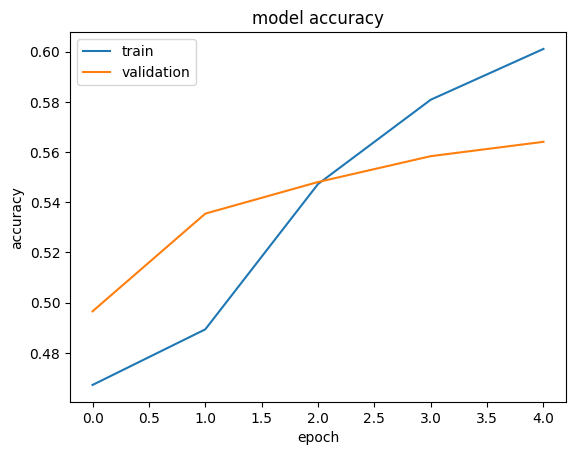

In [83]:
print(hist.history.keys())
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Train LSTM Model without LSTM Layer

In [94]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=10,input_length=padding_size))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
opt = optimizers.Adam(learning_rate=0.001) # tried 0.1, 0.001, 0.0001
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [95]:

hist = model.fit(X_train,
                 to_categorical(y_train),
                 epochs=5, # tried 3, 4, 5, 10
                 batch_size=10,#tried 5, 10, 50, 100
                 validation_data=(X_dev,to_categorical(y_dev)))

Epoch 1/5
787/787 [==============================] - 5s 5ms/step - loss: 1.1977 - accuracy: 0.4964 - val_loss: 1.0313 - val_accuracy: 0.5469
Epoch 2/5
787/787 [==============================] - 2s 2ms/step - loss: 0.9642 - accuracy: 0.5934 - val_loss: 0.9552 - val_accuracy: 0.5870
Epoch 3/5
787/787 [==============================] - 2s 2ms/step - loss: 0.8342 - accuracy: 0.6657 - val_loss: 0.9350 - val_accuracy: 0.5927
Epoch 4/5
787/787 [==============================] - 2s 3ms/step - loss: 0.7219 - accuracy: 0.7241 - val_loss: 0.9468 - val_accuracy: 0.5835
Epoch 5/5
787/787 [==============================] - 2s 3ms/step - loss: 0.6258 - accuracy: 0.7767 - val_loss: 0.9786 - val_accuracy: 0.5767


In [96]:
pred_test_nolstm= np.argmax(model.predict(X_test), axis=1)
print(pred_test_nolstm)
print(accuracy_score(pred_test_nolstm,y_test))
print(recall_score(pred_test_nolstm,y_test,average = 'macro'))
print(f1_score(pred_test_nolstm,y_test,average = 'macro'))
print(precision_score(pred_test_nolstm,y_test,average = 'macro'))

31/31 [==============================] - 0s 2ms/step
[4 4 2 0 4 4 2 2 4 4 3 4 4 3 3 1 3 4 2 3 3 4 4 4 4 4 4 4 2 3 3 2 0 3 4 2 3
 4 3 4 0 4 4 4 2 4 4 4 4 3 3 3 4 3 2 3 4 4 4 3 1 0 1 4 2 2 4 4 4 3 2 3 4 4
 4 4 1 4 4 2 4 3 3 2 4 4 4 3 4 4 3 4 4 3 0 2 4 4 4 4 4 4 3 4 0 3 3 4 4 4 4
 2 3 3 3 4 3 4 4 4 4 4 4 4 3 4 1 1 4 3 3 4 4 1 4 4 4 2 1 4 2 2 2 4 4 4 3 4
 4 3 3 3 4 3 2 2 4 3 3 4 4 4 2 2 2 4 4 3 2 3 3 1 2 4 4 2 4 3 4 4 2 4 4 4 4
 4 4 3 4 3 4 2 3 4 4 2 3 4 4 4 4 4 0 4 1 4 4 4 4 2 4 4 4 1 4 3 3 2 4 3 2 4
 4 4 3 3 3 4 4 0 1 4 4 4 4 2 2 3 2 3 3 4 3 2 4 2 4 3 4 4 0 2 4 4 3 4 4 2 4
 2 3 4 2 0 3 4 4 2 4 4 4 4 3 0 3 2 2 4 2 1 4 4 2 4 4 4 3 1 4 3 4 3 4 3 3 3
 3 3 2 4 4 3 2 3 4 4 3 4 4 1 3 4 4 4 4 4 4 3 4 2 2 3 4 4 4 3 3 4 4 3 4 4 2
 3 3 4 3 4 3 4 4 3 4 4 4 3 4 4 4 4 2 4 4 4 3 4 4 3 4 2 2 4 0 4 4 4 4 0 4 2
 4 2 3 4 3 4 3 4 2 2 3 4 2 4 4 2 1 3 4 4 1 4 2 4 0 4 2 4 3 3 1 4 3 1 4 4 3
 4 4 2 4 3 4 4 4 1 3 4 2 2 3 4 3 3 4 4 3 4 3 4 3 2 4 1 3 4 4 4 3 4 4 2 4 3
 4 2 3 4 4 2 4 2 2 3 4 4 3 4 4 3 4 4 2 3 2 3 3 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


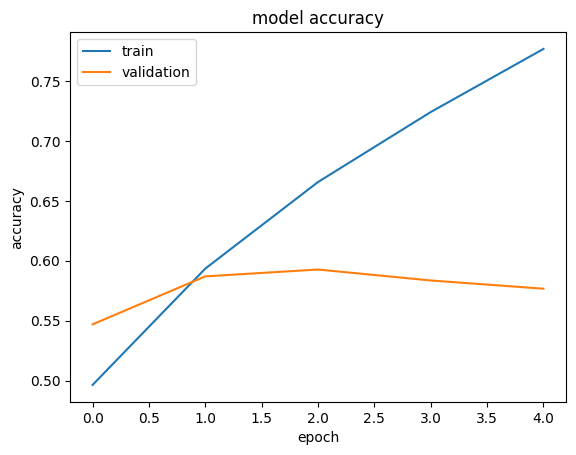

In [97]:
print(hist.history.keys())
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()